# Stock Market Sentiment Analysis

The following Python project aims to retreive a number of articles using the Google News 

In [1]:
# Load necessary packages
import numpy as np
import pandas as pd
import requests
import json
import os
import yfinance as yf
import spacy as sp
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import ast

from datetime import timedelta
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pandas_market_calendars import get_calendar
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


/Users/tmate0733/opt/anaconda3/lib/python3.9/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/Users/tmate0733/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nlp = sp.load("en_core_web_sm")
current_directory = os.getcwd()
os.chdir(current_directory)

# Pipeline
The pipeline includes a number of helpful functions for the project. These will be called in a later code chunk, serving as an overview of control.

In [3]:
def fetch_articles(category, start_date):
    """
    Fetches articles from the specified category within the given date range using the GNews API.

    Parameters:
    - category (str): The category of articles to fetch.
    - start_date (str): The start date of the date range in 'YYYY-MM-DD' format.
    - end_date (str): The end date of the date range in 'YYYY-MM-DD' format.

    Returns:
    - list: A list of dictionaries representing the fetched articles.
    """
    
    api_key = '88edd99823231ee937f06064cd930842'
    url = f"https://gnews.io/api/v4/top-headlines?category={category}&from={start_date}&lang=en&country=us&max=100&apikey={api_key}"
    response = requests.get(url)
    articles = json.loads(response.text)['articles']
    return articles

In [4]:
def calculate_sentiment_scores(text):
    """
    Calculates sentiment scores for the given text using the VADER sentiment analysis tool.

    Parameters:
    - text (str): The text for which sentiment scores are to be calculated.

    Returns:
    - dict: A dictionary containing sentiment scores (neg, neu, pos, compound).
    """
    
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)

In [5]:
def calculate_total_daily_sentiment(scores):
    """
    Calculate the normalized total sentiment score given the daily articles.
    Parameters:
    - scores: Daily articles sentiment scores for which the total score should be calculated.

    Returns:
    - dict: A dictionary containing the neg, pos, neu and compound elements of the total daily sentiment score.
    """
    total_sentiment = {
    'neg': 0,
    'pos': 0,
    'neu': 0,
    'compound': 0
    }

    for score in scores.values():
        total_sentiment['neg'] += score['neg']
        total_sentiment['pos'] += score['pos']
        total_sentiment['neu'] += score['neu']
        total_sentiment['compound'] += score['compound']
    
    # Calculating the total sentiment scores for today
    num_articles = len(scores)
    total_sentiment['neg'] /= num_articles
    total_sentiment['neu'] /= num_articles
    total_sentiment['pos'] /= num_articles
    total_sentiment['compound'] /= num_articles

    return total_sentiment    

In [6]:
def export_sentiment_data(sentiment_scores, date):
    """
    Exports sentiment scores data to a CSV file.

    Parameters:
    - sentiment_scores (dict): A dictionary containing sentiment scores for articles.

    Returns:
    - None
    """

    # Convert data to list of dictionaries
    data_list = []
    for title, scores in sentiment_scores.items():
        row = {'date': date, 'title': title, **scores}
        data_list.append(row)

    # Convert list of dictionaries to DataFrame
    daily_data = pd.DataFrame(data_list)

    folder_path = os.path.join(current_directory, "daily_scores")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Define CSV file name
    csv_file_path = os.path.join(folder_path, f"sentiment_scores_{date}.csv")

    # Export DataFrame to CSV file
    daily_data.to_csv(csv_file_path, index=False)

    print(f"Data has been exported to '{csv_file_path}' successfully.")

In [7]:
def is_trading_day(date):
    # Transform the date parameter into a string if not string already
    if not isinstance(date, str):
        date = date.strftime('%Y-%m-%d')

    # No trading day --> get latest trading day
    sp500_calendar = get_calendar('NYSE')
    return not sp500_calendar.valid_days(start_date=date, end_date=date).empty

In [8]:
def get_sp500_price(start_date):
    """
    Get the adjusted close price of the S&P 500 index from Yahoo Finance for a specific date.
    If the given date is not a trading day for the S&P 500, return the price for the last trading day.

    Parameters:
    - start (datetime.date): Date for which to retrieve the price.

    Returns:
    - float: Adjusted close price of the S&P 500 on the specified date or the last trading day.
    """
    # Transform the date parameter into a string if not string already
    if not isinstance(start_date, str):
        start_date_str = start_date.strftime('%Y-%m-%d')
    else:
        start_date_str = start_date
        start_date = datetime.strptime(start_date, "%Y-%m-%d").date()

    # No trading day --> get latest trading day
    sp500_calendar = get_calendar('NYSE')
    if sp500_calendar.valid_days(start_date=start_date_str, end_date=start_date_str).empty:
        start_date = start_date - pd.tseries.offsets.BDay(1)
        start_date_str = start_date.strftime('%Y-%m-%d')

    # Get the next day as a string
    end_date = start_date + timedelta(days=1)
    end_date_str = end_date.strftime('%Y-%m-%d')

    # Define the ticker symbol for the S&P 500 index
    sp500_ticker = '^GSPC'  # S&P 500 index ticker symbol

    # If the given date is a trading day, fetch historical data for the S&P 500 index from Yahoo Finance
    sp500_data = yf.download(sp500_ticker, start=start_date_str, end=end_date_str)
    
    # Extract the adjusted close price for the specified date
    sp500_price = sp500_data['Adj Close'][0]
    
    return sp500_price

In [9]:
def export_daily_data():
    """
    Reads all CSV files in the current directory starting with 'sentiment_scores'
    and loads them into a pandas DataFrame.

    Returns:
    ----------
    pandas DataFrame: A DataFrame containing the concatenated data from all CSV files.
    """
    # Get a list of all files in the directory that start with 'sentiment_scores' and end with '.csv'
    folder_path = os.path.join(current_directory, "daily_scores")
    files = os.listdir(folder_path)
    csv_files = [file for file in files if file.startswith('sentiment_scores') and file.endswith('.csv')]

    daily_data = pd.DataFrame(columns=['Date', 'Sentiment_Score', 'S&P500'])
    
    # Loop through each CSV file
    for file in csv_files:
        # Read the CSV file into a DataFrame
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        
        articles = {}
        
        # Save each sentiment score row by row
        for index, row in df.iterrows():
            # Extract relevant data into a dictionary
            data_dict = {
                'date': row['date'],
                'neg': row['neg'],
                'pos': row['pos'],
                'neu': row['neu'],
                'compound': row['compound']
            }
            articles[index]=data_dict

        # Calculate total score and sp500 price for the current date
        total_score = calculate_total_daily_sentiment(articles)
        date = df['date'][0]
        sp500 = get_sp500_price(date)
        trading_day = 1 if is_trading_day(date) else 0
        new_row = {'Date': date, 'Sentiment_Score': total_score, 'S&P500': sp500, 'Trading Day?': trading_day}

        # Append the new row to the DataFrame
        daily_data = pd.concat([daily_data, pd.DataFrame([new_row])], ignore_index=True)

    # Save the updated DataFrame to 'daily_data.csv'
    daily_data = daily_data.sort_values(by='Date')
    daily_data.to_csv('daily_data.csv', index=False)
    
    return daily_data

# Retreive articles

Using the API of Google News, I can retrieve the maximum possible number of business news for today.

In [10]:
today = datetime.now().date()

# Load all possible articles for today
category = "business"
articles = fetch_articles(category, today)

# Extract both the title and the description component of all articles
descriptions = [article['description'] for article in articles]

# Calculate sentiment score
Using Vader, I calculate the sentiment score for each article, as well as the given day in total.
I also retrive the daily market price for the S&P 500 and save the data together in a CSV file for each day.
For the S&P 500 prices, only trading dates can be considered, while articles can also be retreived on non-business days.
Therefore, if today's date is no trading day, the S&P 500 price of the last available trading day will be returned.

In [11]:
sentiment_scores = {}

# Text preprocessing and sentiment score calculation
for article in articles:
    current_score = calculate_sentiment_scores(article['description'])
    sentiment_scores[article['title']] = current_score

# Print sentiment score for each article
for key, value in sentiment_scores.items():
    print(key, ':', value)

print(sentiment_scores)

# Calculate total sentiment score for today
total_sentiment = calculate_total_daily_sentiment(sentiment_scores)

# Saving daily CSV file containing sentiment scores
export_sentiment_data(sentiment_scores, today)

# Persisting historic sentiment scores including the SP500 prices
export_daily_data()


Stock Market Today : {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
JetBlue shares tumble after airline lowers 2024 revenue outlook : {'neg': 0.139, 'neu': 0.861, 'pos': 0.0, 'compound': -0.2732}
2024 Toyota Tacoma Hybrid Blows Away Every Truck In Its Segment : {'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compound': 0.357}
Trump Could Pocket Over $1 Billion in Trump Media Stock This Week : {'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.5106}
Trump Is Owed an Extra $1 Billion Stake in Truth Social : {'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'compound': 0.34}
Change Healthcare Finally Admits It Paid Ransomware Hackers-and Still Faces a Patient Data Leak : {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Construction to begin on high-speed rail between Las Vegas and Los Angeles : {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Investors Panic: $206 Million Flees Crypto Funds As Interest Rate Fears Mount, CoinShares Reports : {'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp

,Date,Sentiment_Score,S&P500,Trading Day?
10,2024-04-07,"{'neg': 0.12830000000000003, 'pos': 0.05669999...",5204.339844,0.0
5,2024-04-08,"{'neg': 0.12830000000000003, 'pos': 0.05669999...",5202.390137,1.0
6,2024-04-09,"{'neg': 0.0126, 'pos': 0.1312, 'neu': 0.8561, ...",5209.910156,1.0
8,2024-04-10,"{'neg': 0.022699999999999998, 'pos': 0.1153999...",5160.640137,1.0
9,2024-04-11,"{'neg': 0.0723, 'pos': 0.0696, 'neu': 0.8581, ...",5199.060059,1.0
12,2024-04-12,"{'neg': 0.058699999999999995, 'pos': 0.0507, '...",5123.410156,1.0
11,2024-04-13,"{'neg': 0.1058, 'pos': 0.05569999999999999, 'n...",5123.410156,0.0
16,2024-04-14,"{'neg': 0.1002, 'pos': 0.052700000000000004, '...",5123.410156,0.0
15,2024-04-15,"{'neg': 0.05789999999999999, 'pos': 0.09729999...",5061.819824,1.0
13,2024-04-16,"{'neg': 0.054299999999999994, 'pos': 0.1202999...",5051.410156,1.0


# Diagrams & Results
Creating a Scatterplot comparing the sentiment of the individual articles.

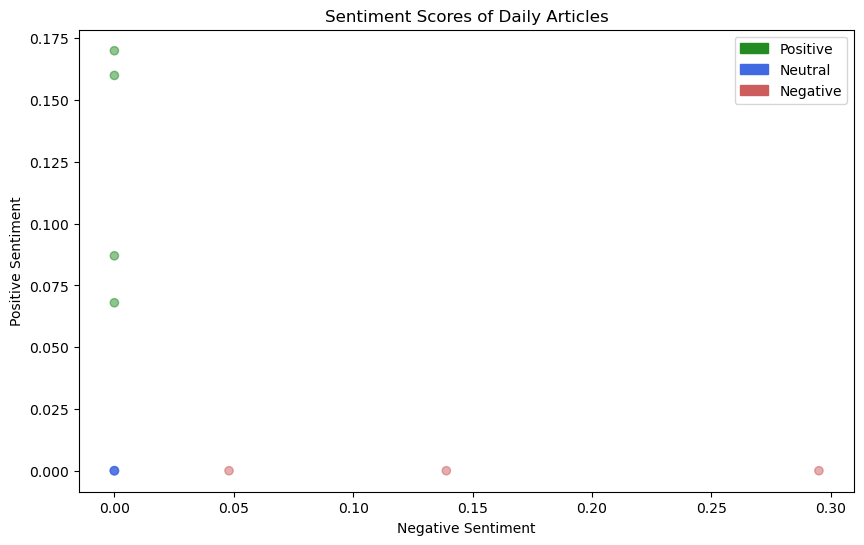

In [12]:
# Separate data for plotting
x = [article['neg'] for article in sentiment_scores.values()]
y = [article['pos'] for article in sentiment_scores.values()]
colors = ['forestgreen' if article['compound'] > 0 else 'royalblue' if article['compound'] == 0 else 'indianred' for article in sentiment_scores.values()]

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, alpha=0.5)
plt.title('Sentiment Scores of Daily Articles')
plt.xlabel('Negative Sentiment')
plt.ylabel('Positive Sentiment')

# Customize legend
green_patch = mpatches.Patch(color='forestgreen', label='Positive')
blue_patch = mpatches.Patch(color='royalblue', label='Neutral')
red_patch = mpatches.Patch(color='indianred', label='Negative')

# Additional plot settings
plt.legend(handles=[green_patch, blue_patch, red_patch], loc='upper right', fontsize='medium')
plt.grid(False)
plt.show()


Creating a Heatmap comparing each sentiment score (incl. compounded) of the individual articles by title.

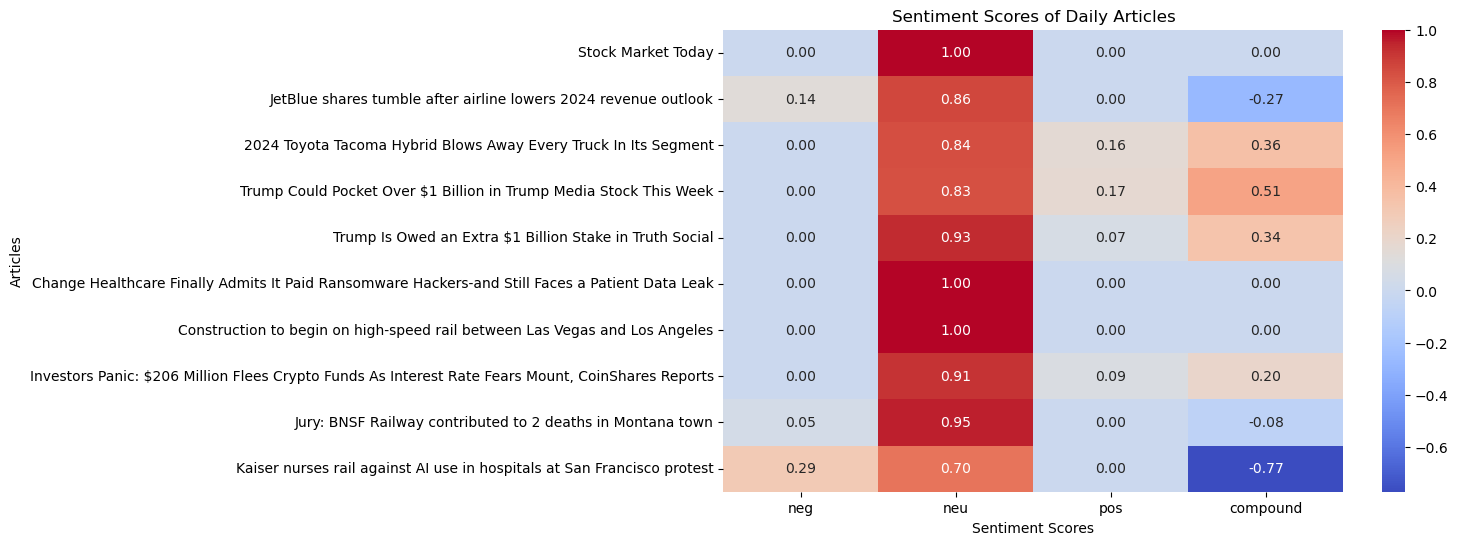

In [13]:
# Create DataFrame based on the data
daily_data = pd.DataFrame(sentiment_scores).T

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(daily_data[['neg', 'neu', 'pos', 'compound']], cmap='coolwarm', annot=True, fmt=".2f")

# Additional plot settings
plt.title('Sentiment Scores of Daily Articles')
plt.xlabel('Sentiment Scores')
plt.ylabel('Articles')
plt.show()


Creating a bar plot displaying the relative sentiment of the market, displayed as the ratio of positive and negative sentiments.
Since sentiment scores can range from -1 to 1, following thresholds values are defined:

- negative: between -1 and -0.1
- neutral: between -0.1 and 0.1
- positive: between 0.1 and 1

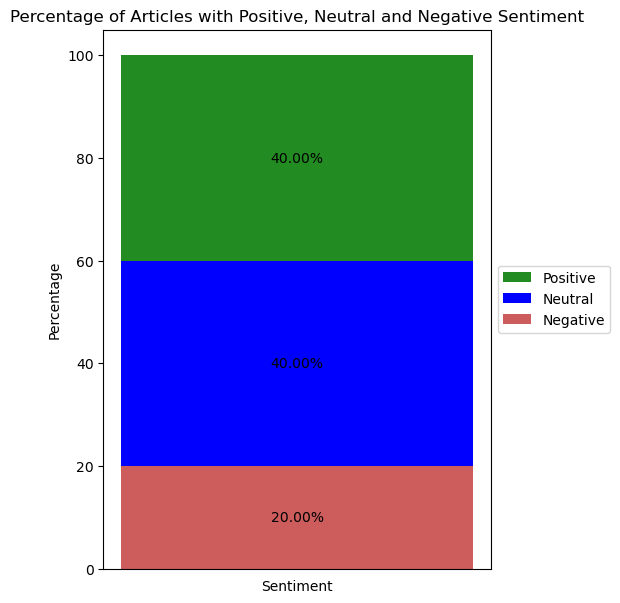

In [14]:
# Count positive and negative articles
positive_count = sum(1 for score in sentiment_scores.values() if score['compound'] > 0.1)
neutral_count = sum(1 for score in sentiment_scores.values() if score['compound'] < 0.1 and score['compound'] > -0.1)
negative_count = sum(1 for score in sentiment_scores.values() if score['compound'] < -0.1)

# Calculate percentages
total_articles = len(sentiment_scores)
positive_percent = (positive_count / total_articles) * 100
neutral_percent = (neutral_count / total_articles) * 100
negative_percent = (negative_count / total_articles) * 100

# Bar Plot
plt.figure(figsize=(5, 7))
plt.bar([0.5], [positive_percent], color='forestgreen', bottom=negative_percent + neutral_percent, label='Positive')
plt.bar([0.5], [neutral_percent], color='blue', bottom=negative_percent, label='Neutral')
plt.bar([0.5], [negative_percent], color='indianred', label='Negative')

# Add text labels
plt.text(0.5, negative_percent / 2, f'{negative_percent:.2f}%', ha='center', va='center')
plt.text(0.5, negative_percent + neutral_percent / 2, f'{neutral_percent:.2f}%', ha='center', va='center')
plt.text(0.5, negative_percent + neutral_percent + positive_percent / 2, f'{positive_percent:.2f}%', ha='center', va='center')

# Additional plot settings
plt.title('Percentage of Articles with Positive, Neutral and Negative Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.xticks([])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Position legend to the right outside of the diagram
plt.show()


# Historic Data & Trend Analysis

I first load the data from daily_data.csv containing the total sentiment score and the S&P 500's price for each day of the observation period.

In [15]:
daily_data = pd.read_csv('daily_data.csv', index_col=0, delimiter=',')
daily_data

,Sentiment_Score,S&P500,Trading Day?
Date,,,
2024-04-07,"{'neg': 0.12830000000000003, 'pos': 0.05669999...",5204.339844,0.0
2024-04-08,"{'neg': 0.12830000000000003, 'pos': 0.05669999...",5202.390137,1.0
2024-04-09,"{'neg': 0.0126, 'pos': 0.1312, 'neu': 0.8561, ...",5209.910156,1.0
2024-04-10,"{'neg': 0.022699999999999998, 'pos': 0.1153999...",5160.640137,1.0
2024-04-11,"{'neg': 0.0723, 'pos': 0.0696, 'neu': 0.8581, ...",5199.060059,1.0
2024-04-12,"{'neg': 0.058699999999999995, 'pos': 0.0507, '...",5123.410156,1.0
2024-04-13,"{'neg': 0.1058, 'pos': 0.05569999999999999, 'n...",5123.410156,0.0
2024-04-14,"{'neg': 0.1002, 'pos': 0.052700000000000004, '...",5123.410156,0.0
2024-04-15,"{'neg': 0.05789999999999999, 'pos': 0.09729999...",5061.819824,1.0


# Machine Learning Model
A Linear Regression Model is trained on the persisted historical data incl. sentiment scores and SP500 prices.
The goal of the model is to learn and predict how news sentiment impact market prices.
The model is always training on all previous observation excluding the last (current day).
Therefore the current day is the test data to predict with.

In [16]:
# Convert string representations of dictionaries to actual dictionaries
data_to_display = daily_data.copy()
data_to_display['Sentiment_Score'] = data_to_display['Sentiment_Score'].apply(ast.literal_eval)

# Extracting compound sentiment scores and S&P500 values
compound_scores = [score['compound'] for score in data_to_display['Sentiment_Score']]
s_and_p = data_to_display['S&P500']

In [17]:
# Extract features and target variable
X_train = np.array(compound_scores)[:-1].reshape(-1,1)
X_test = np.array(compound_scores)[-1].reshape(-1,1)
y_train = np.array(s_and_p[:-1]).reshape(-1,1)
y_test = np.array(s_and_p[-1]).reshape(-1,1)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_regression = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_regression)
print(f"Mean Squared Error: {mse}")
print(f"Predicted S&P 500 price change: {y_pred_regression}")


Mean Squared Error: 1993.7665282830194
Predicted S&P 500 price change: [[5088.0715347]]


Also, a random forest regression model is trained on the same data. The results of the two models are compared based on the MSE.

In [18]:
# Train the random forest regressor model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_rf = model.predict(X_test.reshape(1, -1))

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error: {mse}")
print(f"Predicted S&P 500 price change: {y_pred_rf}")


Mean Squared Error: 6518.317622447175
Predicted S&P 500 price change: [5124.15602051]


/var/folders/_b/y53qt2896kq2xm42py9r4fmh0000gn/T/ipykernel_11966/1532119121.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


I load the previous predictions of the Random Forest model and append the current prediction.
The upadted data is stores as CSV again.

In [19]:
predictions = pd.read_csv('predictions.csv', index_col=0)
predictions

,Predictions
2024-04-07,5204.339844
2024-04-08,5204.339844
2024-04-09,5202.858066
2024-04-10,5207.372847
2024-04-11,5175.859531
2024-04-12,5198.954077
2024-04-13,5155.802075
2024-04-14,5191.907935
2024-04-15,5173.787495
2024-04-16,5169.770425


In [20]:
new_row = pd.Series({'Predictions': y_pred_rf[0]}, name=today)

if str(today) in predictions.index:
    predictions.update(new_row)
else:
    predictions = pd.concat([predictions, pd.DataFrame([new_row])], ignore_index=False)

predictions.to_csv('predictions.csv')
predictions

,Predictions
2024-04-07,5204.339844
2024-04-08,5204.339844
2024-04-09,5202.858066
2024-04-10,5207.372847
2024-04-11,5175.859531
2024-04-12,5198.954077
2024-04-13,5155.802075
2024-04-14,5191.907935
2024-04-15,5173.787495
2024-04-16,5169.770425


Using a line chart, I display the historic
- S&P 500 Prices
- Sentiment Scores
- Random Forest Predicitons

I shift the predictions by one to see the previous day's prediction each day.
Since there is no prediction available for the first day, I plot starting with the second data point.

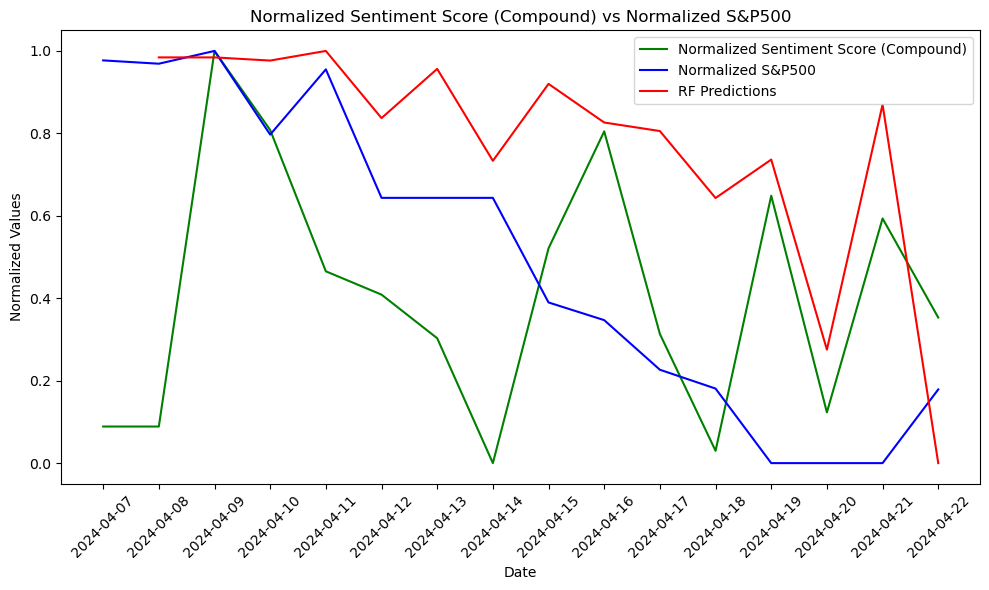

In [21]:
# Normalize the values
scaler = MinMaxScaler()
compound_scores_normalized = scaler.fit_transform(np.array(compound_scores).reshape(-1, 1)).flatten()
s_and_p_normalized = scaler.fit_transform(np.array(s_and_p).reshape(-1, 1)).flatten()
predictions_normalized = scaler.fit_transform(np.array(predictions.shift(1)).reshape(-1,1)).flatten()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index[:-1], compound_scores_normalized[:-1], label='Normalized Sentiment Score (Compound)', color='green')
plt.plot(daily_data.index[:-1], s_and_p_normalized[:-1], label='Normalized S&P500', color='blue')
plt.plot(daily_data.index[:-1], predictions_normalized[:-1], label='RF Predictions', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Normalized Sentiment Score (Compound) vs Normalized S&P500')
plt.xticks(rotation=45)
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()


We can observe that model learns pretty quickly what the flag 'Trading day?' means for the price.
During a weekend, Sunday's price will always be the same as Saturday's price, sicne the market is closed.